## Driving an Jupyter notebook from GA4GH Data Connect schema
This notebook explores how the schema available via GA4GH Data Connect can be used to drive a user interface. In this case a Jupyter notebook.


>Note: The sequence files used in this notebook are  under controlled access. You will not be able to access those files unless you have been granted access through dbGaP to the phs001554 study. If you have that access you will also have access to the non-scrambled subject and sample data. If that is the case, we would be pleased to hear of your interest, and the possibility of collaborating to ensure the GA4GH tools described here enable your studies. Please see [form to register interest](https://docs.google.com/forms/d/e/1FAIpQLSfmmc3VKd6ANdzaVMyelT3c9gIWuoS4ZwT0vsqD-o2ZRxJf7A/viewform)

In [11]:
from fasp.search import DataConnectClient
searchClient = DataConnectClient('http://localhost:8089/')

In [19]:
query = '''SELECT f.sample_name, drs_id bam_drs_id, acc, population, 
race, ethnicity, weight
FROM tutorial.onek_genomes.ssd_drs s 
join tutorial.onek_genomes.sra_drs_files f on f.sample_name = s.su_submitter_id 
where filetype = 'bam' and mapped = 'mapped' 
and sequencing_type ='exome'  
 '''
df = searchClient.runQuery(query, returnType='dataframe')

Retrieving the query
____Page1_______________
____Page2_______________
____Page3_______________
____Page4_______________
____Page5_______________
____Page6_______________
____Page7_______________
____Page8_______________
____Page9_______________
____Page10_______________


In [20]:
df

,sample_name,bam_drs_id,acc,population,race,ethnicity,weight
0,HG00126,c920c2d573cde0550babb81084d4ca9a,SRR1599309,GBR,None,None,None
1,HG00129,e52e3b0b68e4820099af23e26f39389b,SRR1600428,GBR,None,None,None
2,HG00148,f9f929c42759a7a2560f8d1881ff6269,SRR1600444,GBR,None,None,None
3,HG01280,27f417c7e8efe1e7e2a8ff6d5bf0d601,SRR1606941,CLM,None,None,None
4,HG03298,21dfd21d80bd593440d2d5a3fe0cdb92,SRR1602396,ESN,None,None,None
...,...,...,...,...,...,...,...
2499,NA19095,9b10a7d693344e9f6f69dcac7eeccb64,SRR1604303,YRI,None,None,None
2500,NA19129,1e686490f1d847d5271e1a134957b15c,SRR1603935,YRI,None,None,None
2501,NA19093,aaf7ee048af703a0a131cd17eeb94598,SRR1606676,YRI,None,None,None
2502,NA19201,755339fc875c0ae8bf4a27ff3186c9e5,SRR1603916,YRI,None,None,None


In [21]:
def getColValues(info, columns):
    enumVals = {}
    for column in columns:
        var = info['data_model']['properties'][column]
        valueList = []
        for value in var['oneOf']:
            valueList.append(value['const'])
        enumVals[column] = valueList
    return enumVals
    
info = searchClient.listTableInfo('tutorial.onek_genomes.ssd_drs').schema
#enumCols = getColValues(info, ['population', 'sex', 'race', 'study'])
enumCols = getColValues(info, ['population'])

print(enumCols)

{'population': ['ACB', 'ASW', 'BEB', 'CDX', 'CEU', 'CHB', 'CHS', 'CLM', 'ESN', 'FIN', 'GBR', 'GIH', 'GWD', 'IBS', 'ITU', 'JPT', 'KHV', 'LWK', 'MSL', 'MXL', 'PEL', 'PJL', 'PUR', 'STU', 'TSI', 'YRI']}


### Build a study specific user interface from the information the GA4GH Data Connect Schema
Use IPython widgets to filter data from the retrived data frame. the controls of the interface are configured using the schema provided by GA4GH Search.

In [22]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, IntRangeSlider

def filter_gecco(
                 population=enumCols['population']
                ):
    
    selected_df = df.loc[ (df['population'] == population) ]
    drs_ids = selected_df['bam_drs_id'].tolist()
    return drs_ids

drs_list = interact(filter_gecco,  

                 population=enumCols['population']
                )

interactive(children=(Dropdown(description='population', options=('ACB', 'ASW', 'BEB', 'CDX', 'CEU', 'CHB', 'C…

To do: Retrieve the filtered data frame and submit the selected files for compute.

In [4]:
drsClient = crdcDRSClient('/Users/forei/.keys/crdc_credentials.json', 's3')

settings = faspRunner.settings
wesClient = sbcgcWESClient(settings['SevenBridgesProject'])

faspRunner.configure(searchClient, drsClient, wesClient)
run_ids = faspRunner.runDRSIDs(query, runNote)
import pandas as pd
runs_df = pd.DataFrame(run_ids)
runs_df

drsID=s
{"msg":"No bundle found","status_code":404}



TypeError: 'int' object is not subscriptable

In [86]:
merged_df = pd.merge(
    df,
    runs_df,
    how="inner",
    left_on='acc',
    right_on='subject'
)
merged_df.drop('subject', axis=1, inplace=True)
merged_df.drop('drs_id', axis=1, inplace=True)
merged_df.to_csv('~/mywork.csv')
merged_df

,acc,sample_id,sex,age,run_id
0,SRR7271762,117454,Male,54,95070d33-b4f0-46f9-9aa7-82ee0b0123b4
1,SRR7271780,117477,Female,55,7bac5691-d9fb-4e05-8d03-8b6979b08ab9
2,SRR7271789,117486,Male,55,7cf35851-2f16-4b87-94fa-132b54960ba6


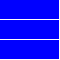

In [9]:
faspRunner.getFASPicon()

Update the dataframe with the status of the runs

In [92]:
for index, row in merged_df.iterrows():
    status = wesClient.getTaskStatus(row['run_id'])
    merged_df.at[index, "status"] = status
merged_df

,acc,sample_id,sex,age,run_id,status
0,SRR7271762,117454,Male,54,95070d33-b4f0-46f9-9aa7-82ee0b0123b4,COMPLETE
1,SRR7271780,117477,Female,55,7bac5691-d9fb-4e05-8d03-8b6979b08ab9,COMPLETE
2,SRR7271789,117486,Male,55,7cf35851-2f16-4b87-94fa-132b54960ba6,COMPLETE


Once the runs have completed the results can be retrieved.

First two convenience functions are defined

In [93]:
import requests
import os
def download(url, file_path):
    with open(os.path.expanduser(file_path), "wb") as file:
        response = requests.get(url)
        file.write(response.content)
        
def getStats(filePath, statsList):
    ''' Extract values from a SAMTools Stats results file'''
    ### 
    
    retDict = {}
    f = open(filePath, "r")
    for x in f:
        if x.startswith('SN'):   
            parts = x.split('\t')
            statName = parts[1].split(':')[0]
            if statName in statsList:
                retDict[statName] = parts[2].rstrip()
    return retDict
        


In [97]:
from fasp.loc import DRSMetaResolver
mr = DRSMetaResolver()
statsList = []
for index, row in merged_df.iterrows():
    log = wesClient.GetRunLog(row['run_id'])
    resultsDRSID = log['outputs']['statistics']['path']
    url = mr.getAccessURL2(resultsDRSID,'s3')
    fileName = log['outputs']['statistics']['name']
    download(url, fileName)
    statsRequired = ['insert size average','insert size standard deviation']
    stats = getStats(fileName, statsRequired)
    stats['acc'] = row['acc']
    statsList.append(stats)
    os.remove(fileName)
stats_df =  pd.DataFrame(statsList)

Searching the GA4GH registry for org.ga4gh:drs services


In [98]:
stats_df

,insert size average,insert size standard deviation,acc
0,353.2,90.4,SRR7271762
1,346.4,84.8,SRR7271780
2,334.9,92.1,SRR7271789


In [99]:
final_df = pd.merge(
    merged_df,
    stats_df,
    how="inner",
    left_on='acc',
    right_on='acc'
)
final_df.drop('status', axis=1, inplace=True)
final_df.drop('run_id', axis=1, inplace=True)

final_df

,acc,sample_id,sex,age,insert size average,insert size standard deviation
0,SRR7271762,117454,Male,54,353.2,90.4
1,SRR7271780,117477,Female,55,346.4,84.8
2,SRR7271789,117486,Male,55,334.9,92.1
